In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sbn 
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib
#load the data

In [2]:
data= pd.read_csv('real_estate.csv')

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          414 non-null    float64
 1   house_age                 414 non-null    float64
 2   transit_distance          414 non-null    float64
 3   local_convenience_stores  414 non-null    int64  
 4   latitude                  414 non-null    float64
 5   longitude                 414 non-null    float64
 6   price_per_unit            414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


it shows that there are not null values or missing values

In [4]:
df= data.copy()
#Create the feature year and month
df['year'] = df['transaction_date'].astype('int')
df['month'] = ((df['transaction_date'] - df['year']) * 12).astype('int') + 1

In [5]:
df= df.drop('transaction_date',axis=1)

Now check the outliers for everthing but we only going to focus in the variable that we need predict

In [6]:
def plotbox(e):
    for i in ((e.columns.values)):
        plt.figure(figsize=(10,6))
        sbn.boxplot(x=e[i])

<Axes: xlabel='price_per_unit', ylabel='Count'>

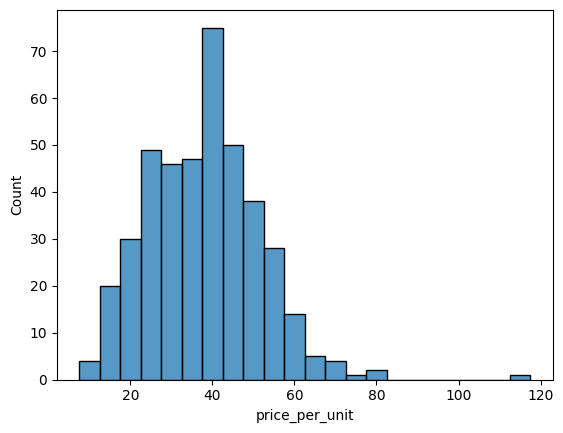

In [7]:
sbn.histplot(df['price_per_unit'])    

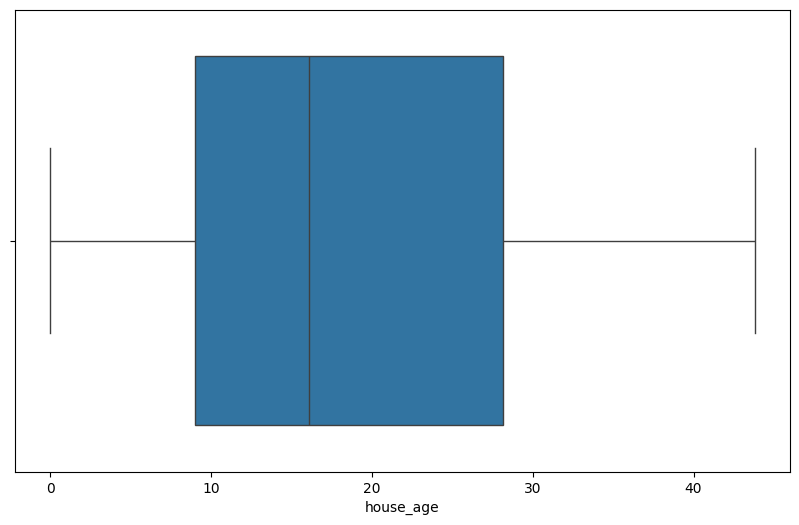

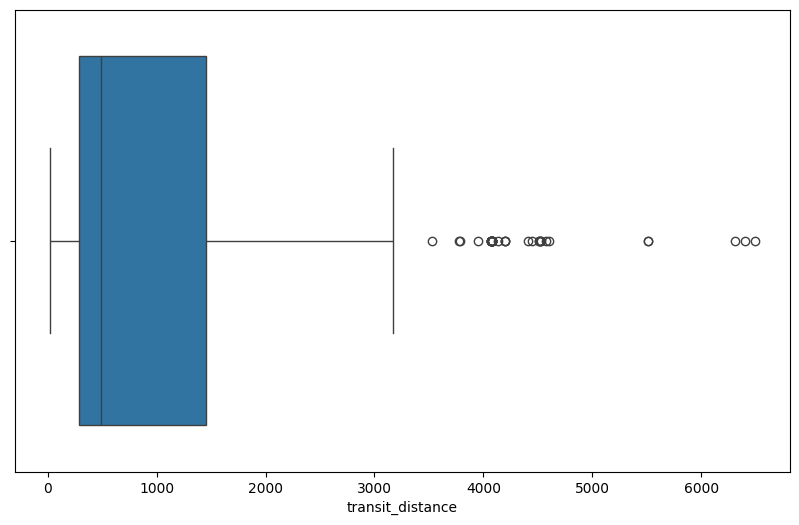

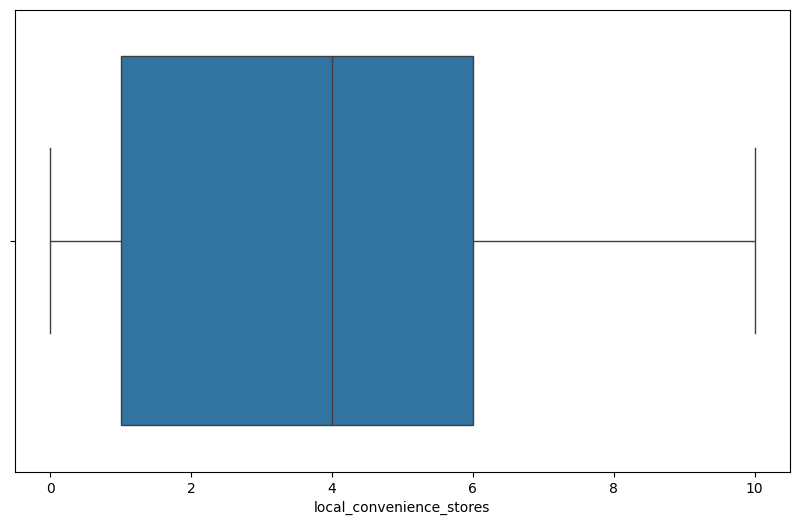

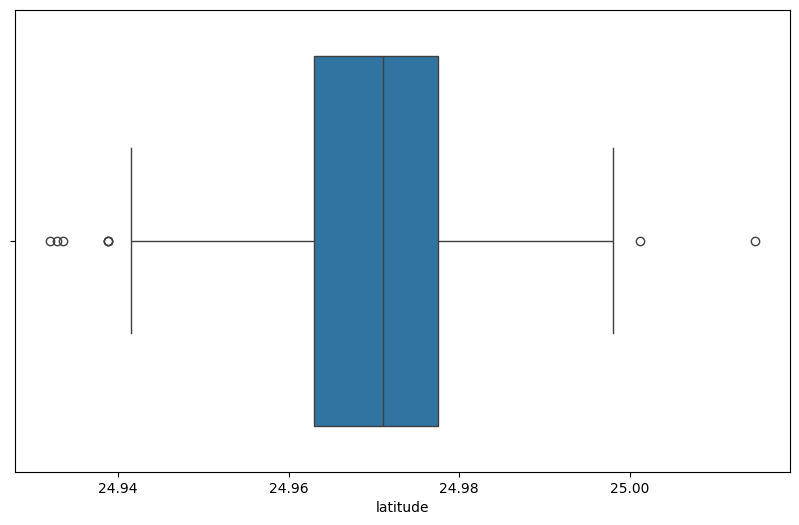

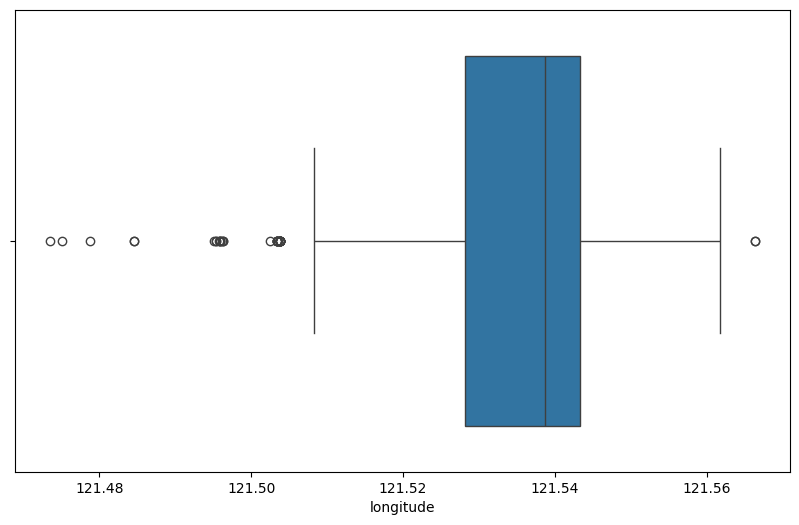

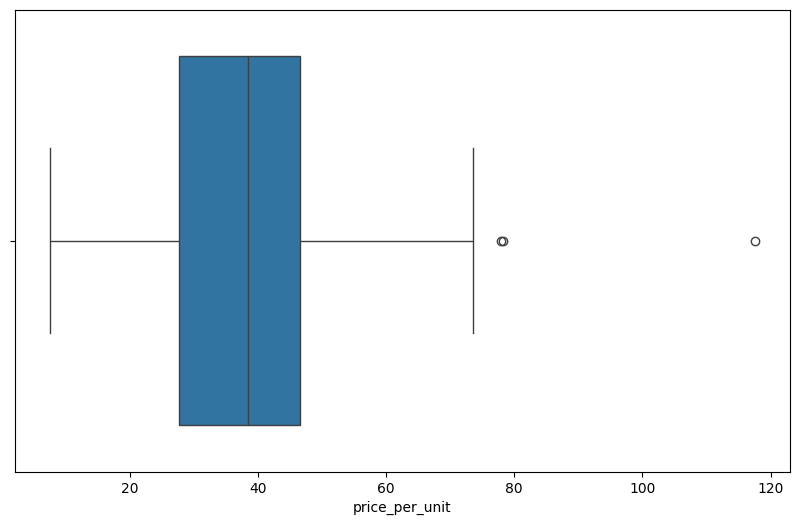

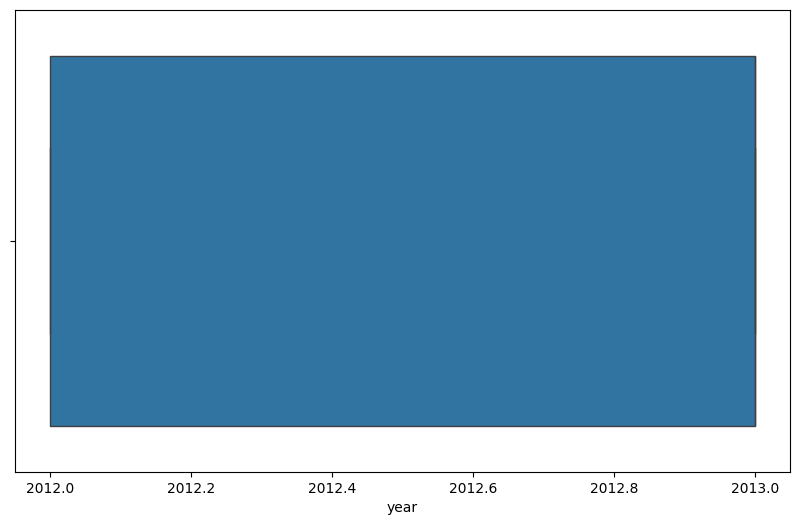

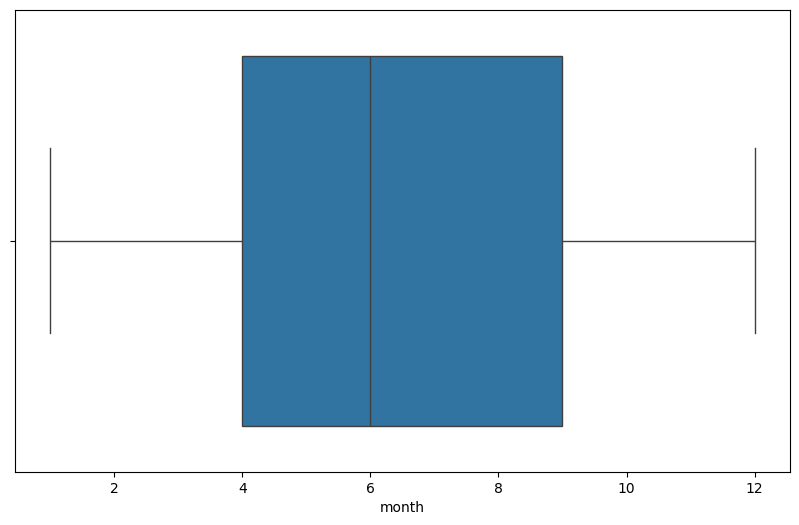

In [8]:
plotbox(df)

In [9]:
#The boxplots and histplot show that there are some outliers in transit_distance and in price_per_unit features 
#But let's focus in price_per_unit feature
#We will remove the outliers using the IQR method
#First we need to calculate the IQR
q1= df['price_per_unit'].quantile(0.25)
q3 = df['price_per_unit'].quantile(0.75)

In [10]:
iqr= q3 - q1
#Then set the upper and lower limit
upper_limit= q3 + (1.5*iqr)
lower_limit = q1 - (1.5*iqr)
#Then remove the outliers
df.loc[df['price_per_unit'] > upper_limit, 'price_per_unit'] = upper_limit
df.loc[df['price_per_unit'] < 0, 'price_per_unit'] = 0

<Axes: xlabel='price_per_unit', ylabel='Count'>

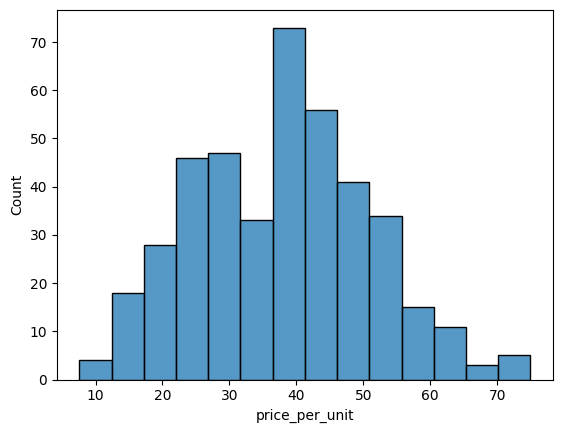

In [11]:
sbn.histplot(df['price_per_unit'])    

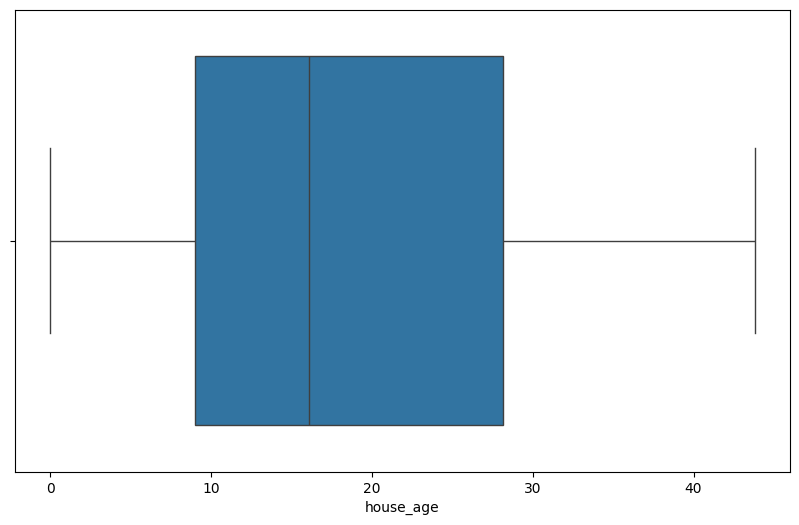

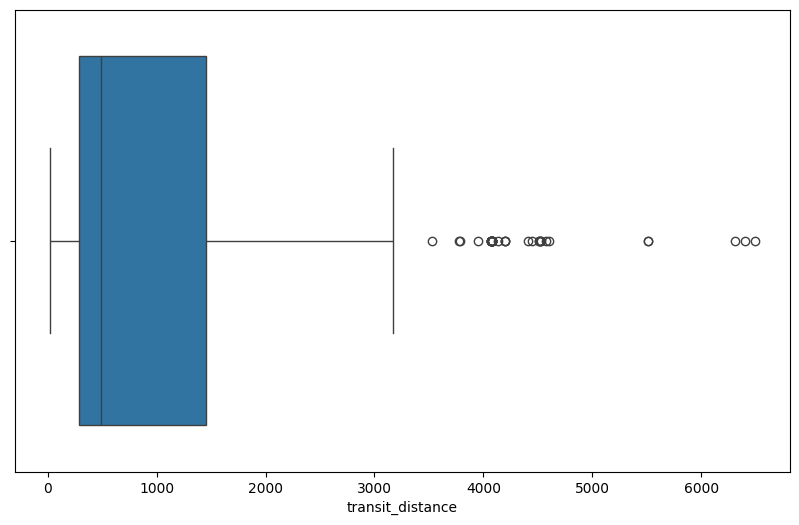

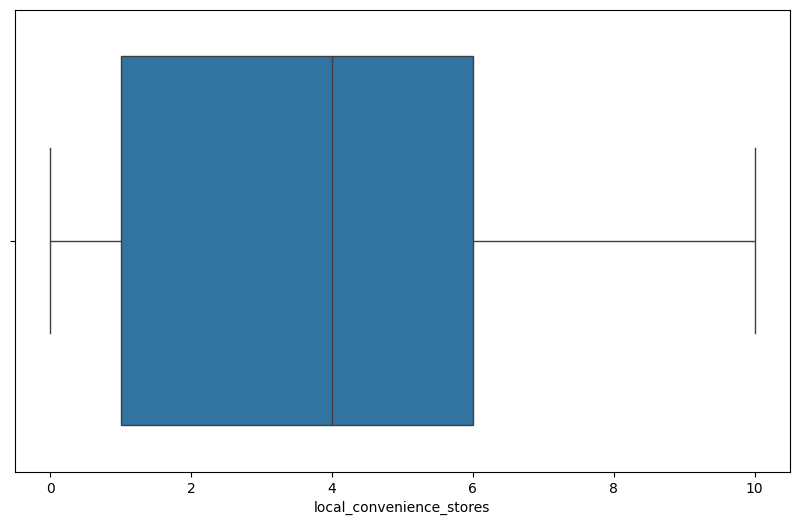

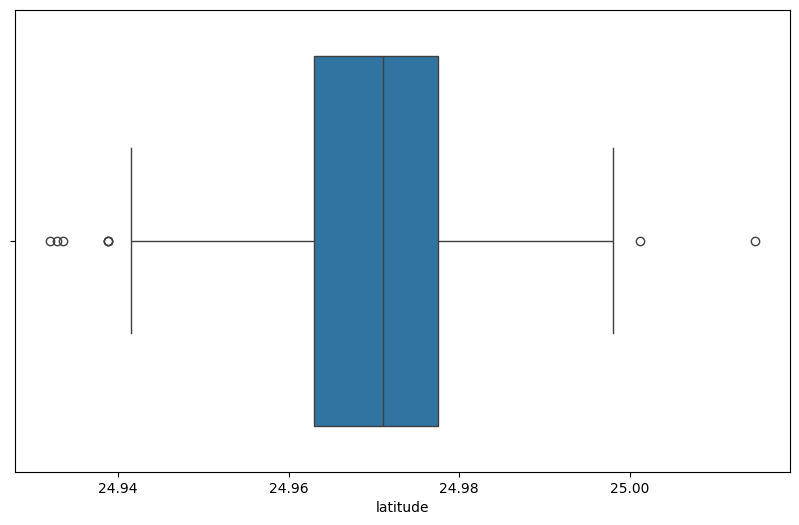

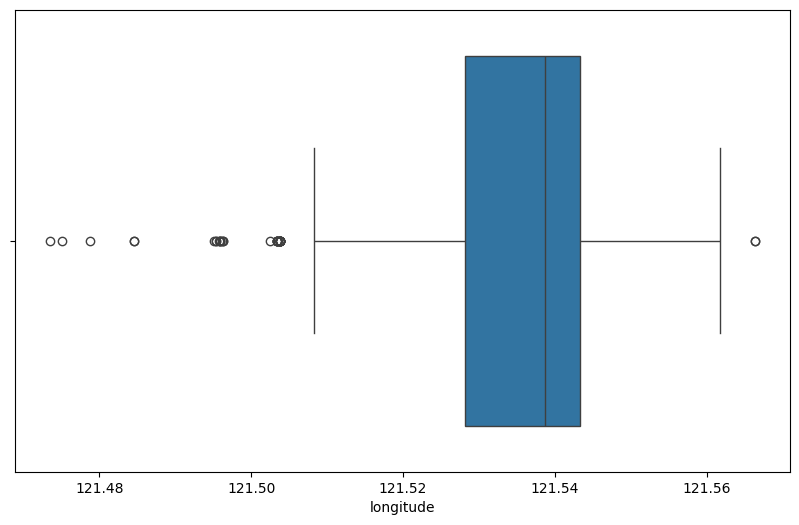

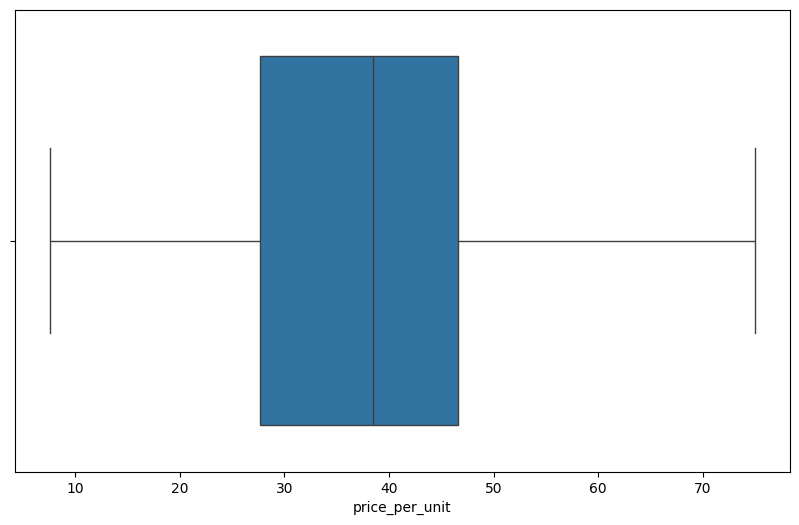

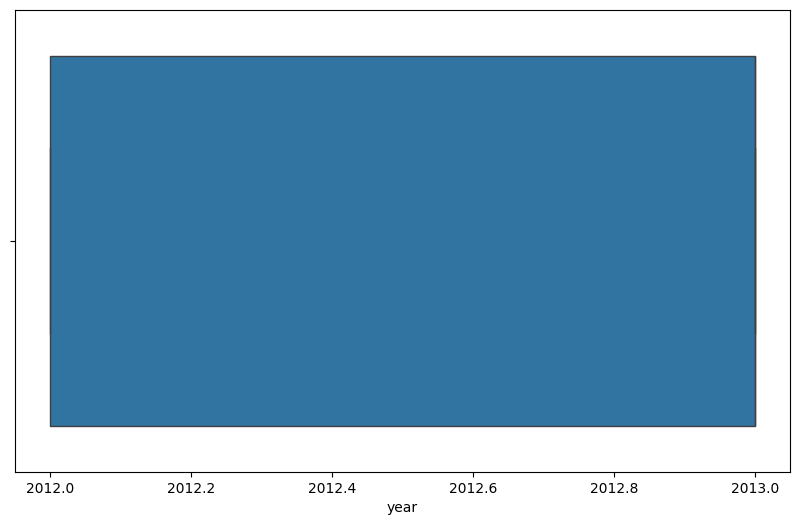

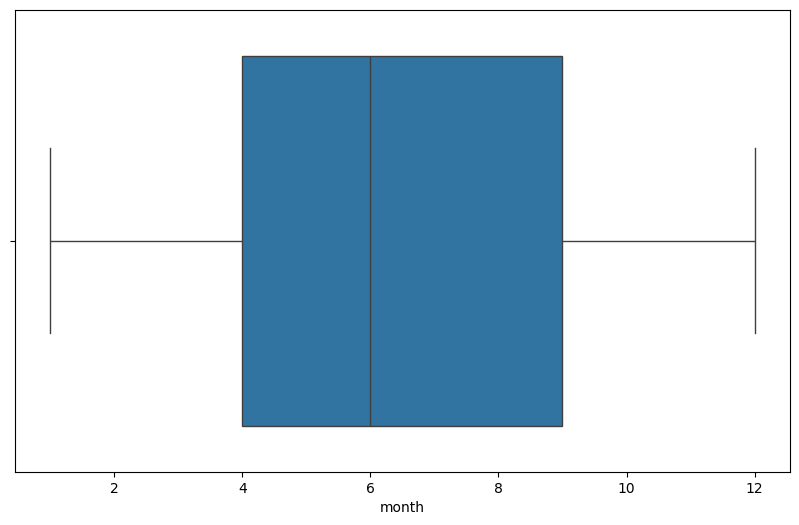

In [12]:
plotbox(df)

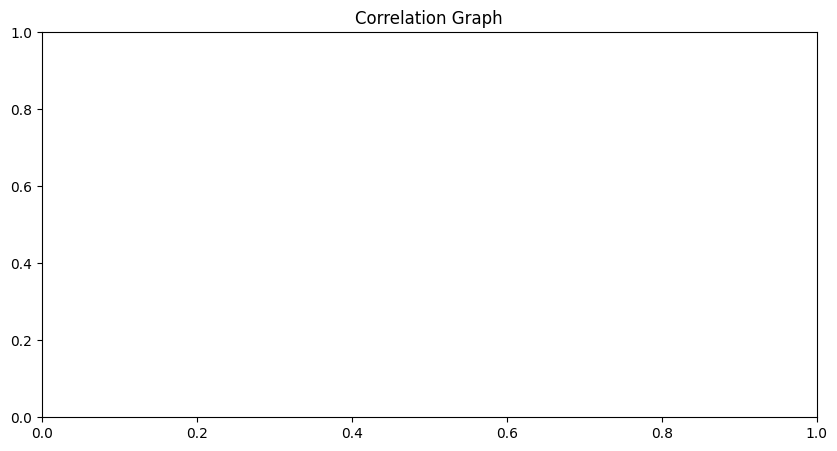

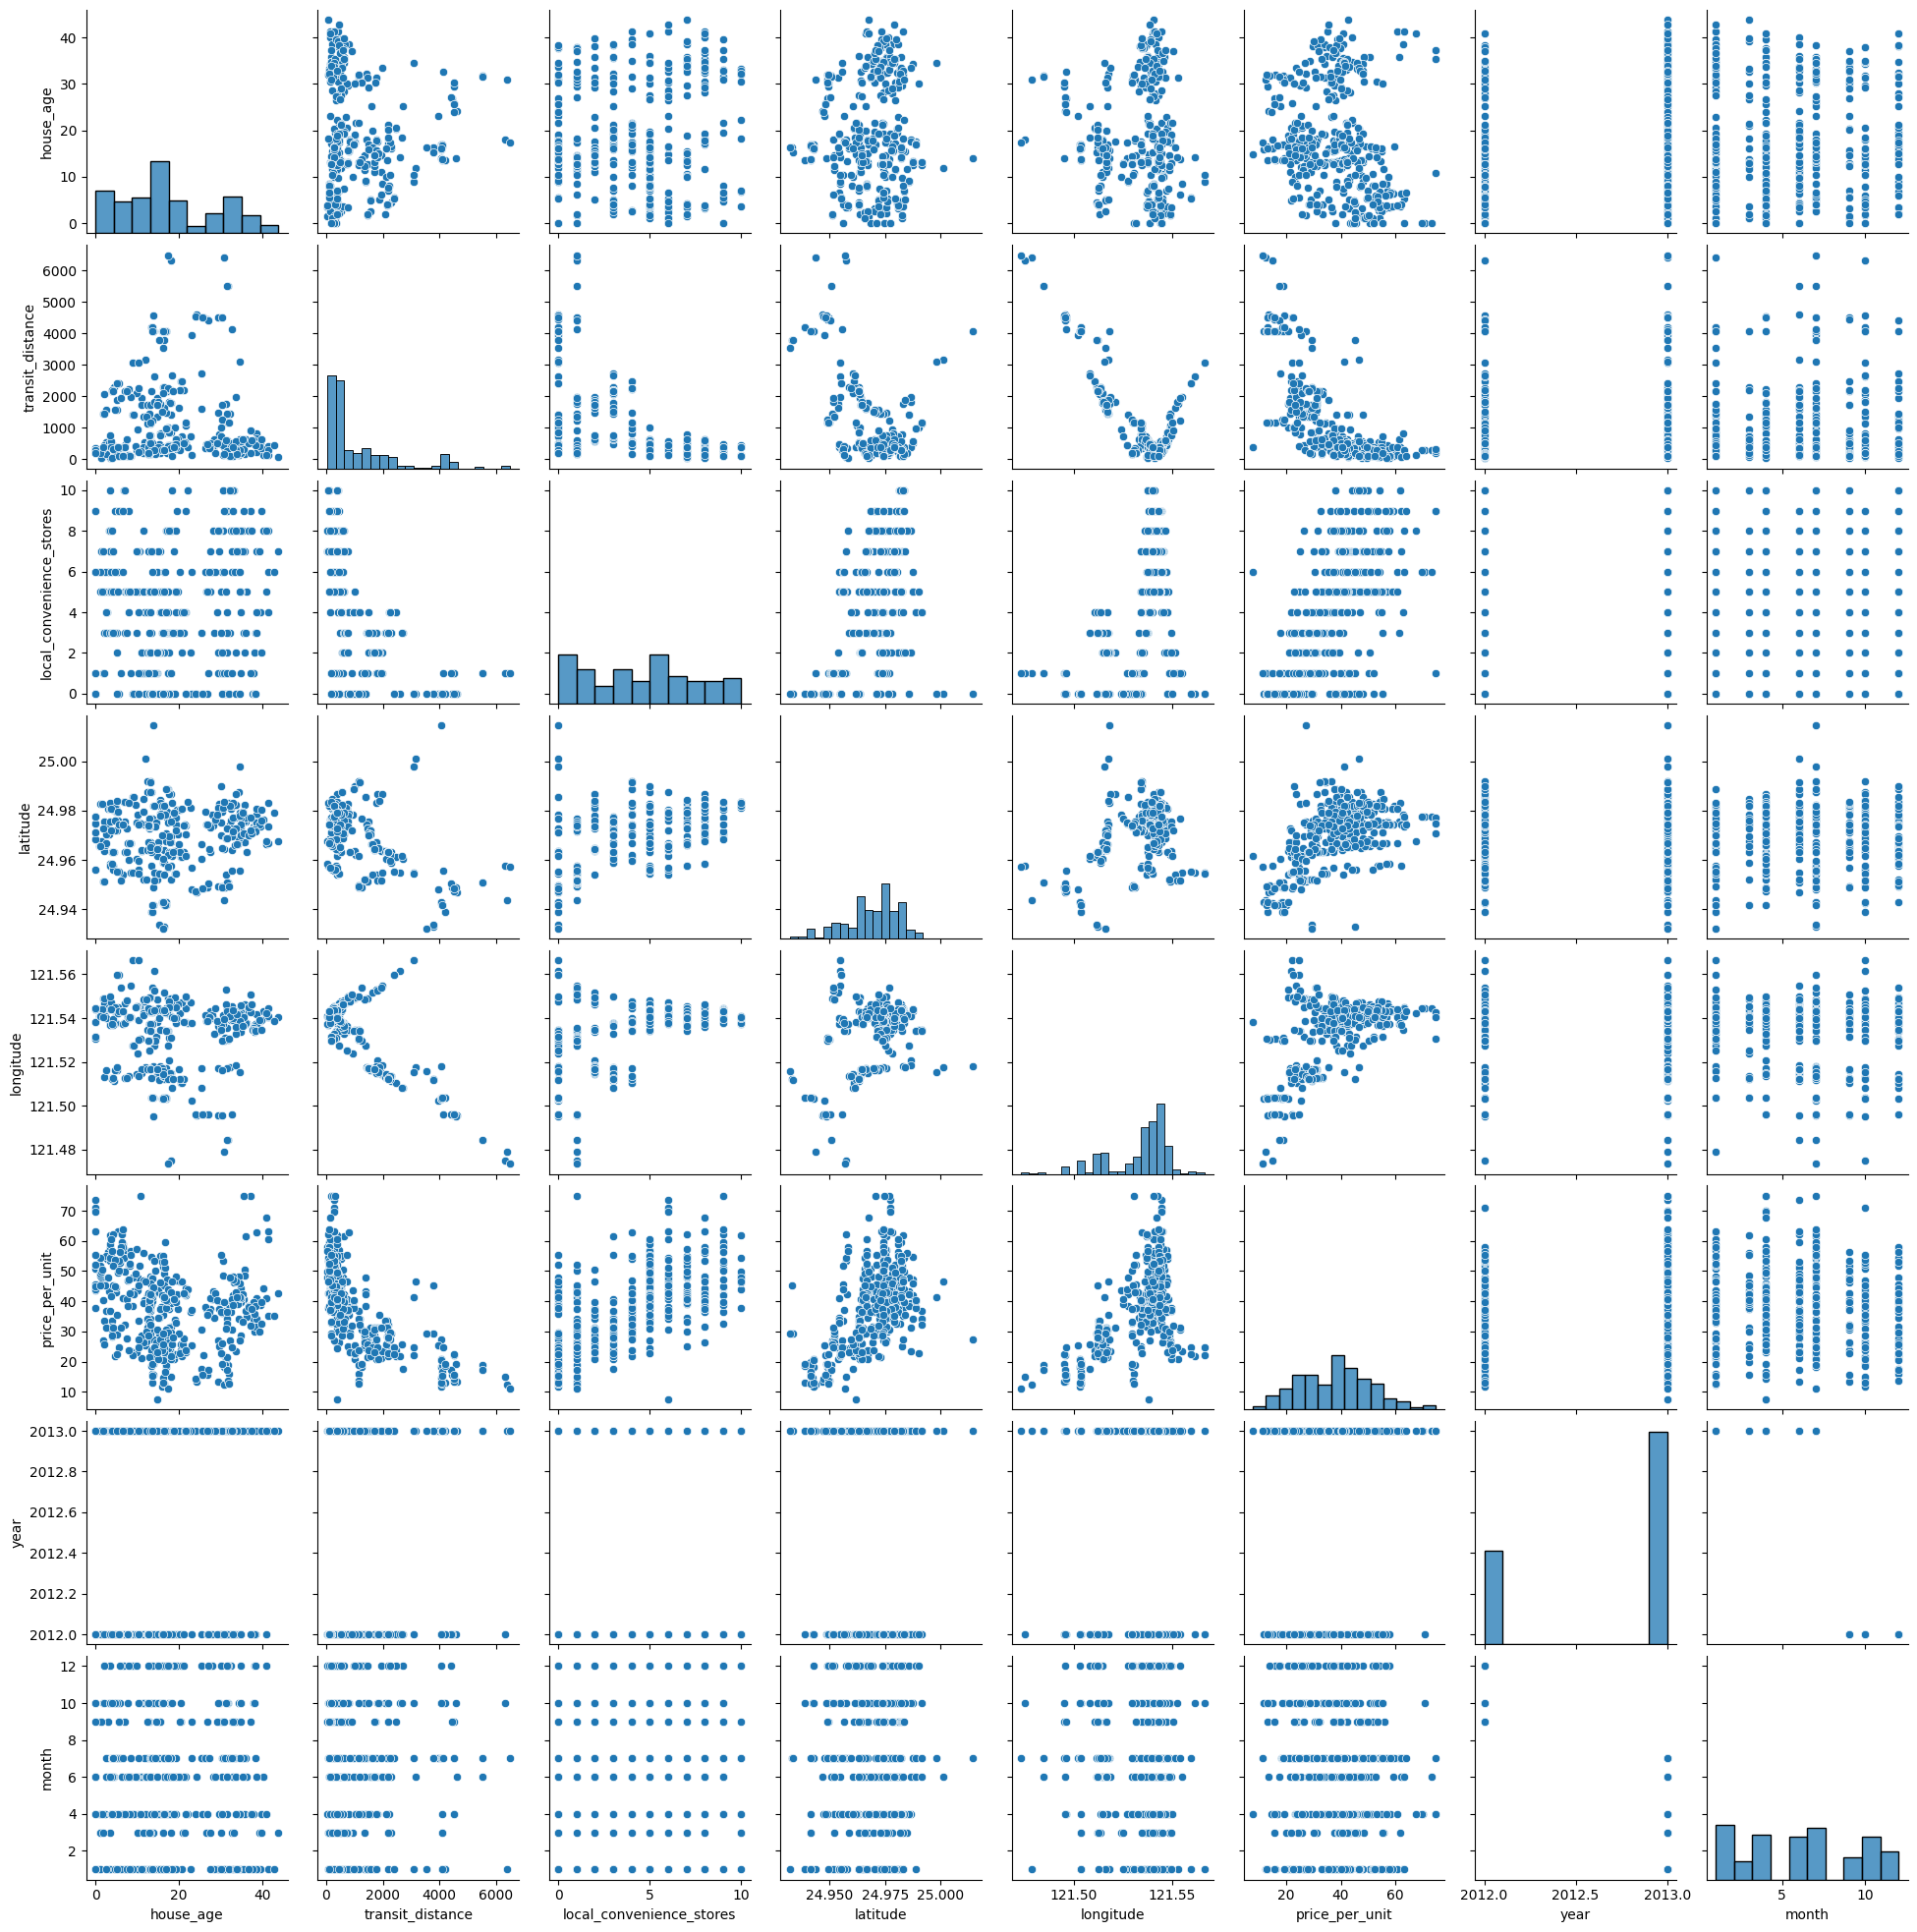

In [13]:
#Now we have removed the outliers and we have a normal distribution in price_per_unit feature
#Now let's check the numeric correlations
plt.figure(figsize=(10,5))
plt.title('Correlation Graph')
sbn.pairplot(df)

In [14]:
#Like year and month doesn't have a great correlation let's ignore this
df= df.drop(['year','month'],axis=1)
#Now that we have the possible corelation between features let's split the data

We will use the train_test_split function from sklearn library

In [15]:
X= df.drop('price_per_unit',axis=1)
y= df['price_per_unit']

In [16]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.30 , random_state=42)

Like we want to predict a numeric features but in the correlation map it shows that the features don't have to significant correlation then let's try a Random Forest Regressor
We will use the RandomForestRegressor from sklearn library

But first let's preproccess the data like scale the date.

In [17]:
#Normal way
'''
scaler= StandardScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)

x_test_scaled = scaler.transform(x_train)

randomForest=  RandomForestRegressor(random_state=42)

randomForest.fit(x_train_scaled,y_train)

'''

'\nscaler= StandardScaler()\n\nscaler.fit(x_train)\n\nx_train_scaled = scaler.transform(x_train)\n\nx_test_scaled = scaler.transform(x_train)\n\nrandomForest=  RandomForestRegressor(random_state=42)\n\nrandomForest.fit(x_train_scaled,y_train)\n\n'

Using pipeline

In [18]:
# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,2,3,4]
numeric_transformer= Pipeline(steps=[('scaler',StandardScaler())])

Combining preprocessing steps

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ])

In [20]:
modeltype= RandomForestRegressor(random_state=42)

In [21]:
# Create preprocessing and training pipeline
pipeline=  Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', modeltype)])

fit the pipeline to train a linear regression model on the training set

In [22]:
modelRandomForest= pipeline.fit(x_train,y_train)

In [23]:
predictRF=  modelRandomForest.predict(x_test)

To evaluate the metrics

In [24]:
def scoresRegressor(pred,d_test):
         mse = mean_squared_error(d_test, pred)
         print("MSE: {0}".format(round(mse,2)))
         rmse = np.sqrt(mse)
         print("RMSE: {0}".format(round(rmse,2)))
         r2 = r2_score(y_test, pred)
         print("R2: {0}".format(round(r2,2)))

In [25]:
scoresRegressor(predictRF,y_test)

MSE: 42.28
RMSE: 6.5
R2: 0.75


And now is time to plot the predict values vs the true values

Text(0, 0.5, 'actual values')

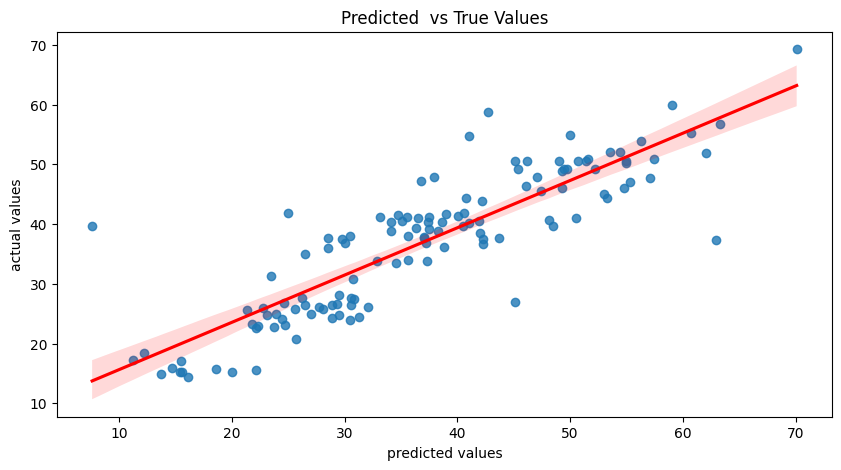

In [26]:
plt.figure(figsize=(10,5))
sbn.regplot(x=y_test,y= predictRF,line_kws=dict(color="r"))
plt.title('Predicted  vs True Values')
plt.xlabel('predicted values')
plt.ylabel('actual values')

In [27]:
# Save the model as a pickle file
filename = './real_estate_model.pkl'
joblib.dump(modelRandomForest, filename)

['./real_estate_model.pkl']

In [28]:
# Load the model from the file
loaded_model = joblib.load(filename)

In [29]:
X_new = np.array([[16.2,289.3248,5,24.98203,121.54348],
                  [13.6,4082.015,0,24.94155,121.5038]])

In [30]:
results = loaded_model.predict(X_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))

Predictions:
50.62
15.18


C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
